## Goal

To produce datapoints in 7d space by building 7-spheres in all orthants (2 concentric spheres of radii, say, 1 and 2 in all orthants,
centered at say, a distance of 4 from all axes) in a non-uniform fashion, i.e., some orthants would have fewer points and some more points
(say, 25% of the orthants have fewer points, perhaps ~25 points in most orthants and ~4 points in the rarer orthants).

We wish to determine the performance of a neural network for different orthants - does it perform equally well or similar in all orthants,
determining that there is symmetry present in the data? Or does it fail to do so, doing well only in the orthants with more data? We use a
test set of say, 128 points per orthant to quantify each orthant's performance.

## Data

### Defining constants

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
LOW_COUNT = 4   # Average no. of points in a "rare" orthant
HIGH_COUNT = 25 # Average no. of points in a "typical" orthant
LOW_SPREAD = 2  # Allowed unidirectional deviation for no. of points in a "rare" orthant (i.e., 2 to 6 points)
HIGH_SPREAD = 8 # Allowed unidirectional deviation for no. of points in a "typical" orthant (i.e., 17 to 33 points)
VAL_COUNT = 4   # Validation data points per orthant
TEST_COUNT = 64 # Test data points per orthant, for final pattern
LOW_FRAC = 0.25 # Fraction of "rare" orthants
ZERO_FRAC = 0.25    # Fraction of empty orthants from rare orthants

In [3]:
CENTRE = 4 * torch.ones(7)
# The centre of the 7-spheres, without orthant-specificity, which can be included using ORTHANTS
CENTRE

tensor([4., 4., 4., 4., 4., 4., 4.])

In [4]:
LOW_RADIUS = 1. # Radius of the inner sphere (say, label 0) in each orthant
HIGH_RADIUS = 2.    # Radius of the outer sphere (say, label 1) in each orthant

### Data generation

Each datapoint is sampled by Muller's method, sampling 7 values from a standard Gaussian distribution and normalizing to fall on a unit sphere. This now provides the unit direction vector from the centre of the sphere.

$$
\boldsymbol{d} \sim \mathcal{N}(\boldsymbol{0}_7, \boldsymbol{I}_7) \\
\boldsymbol{x} = \boldsymbol{C} + r * \boldsymbol{d}
$$

#### Train data

In [5]:
from scripts.data.orthants import generate_train_data, generate_test_data, generate_flips

In [6]:
flips = generate_flips(0.2)

In [7]:
X_training, Y_training, orthant_counts = generate_train_data()
X_training.shape, Y_training.shape

(torch.Size([4901, 7]), torch.Size([4901, 1]))

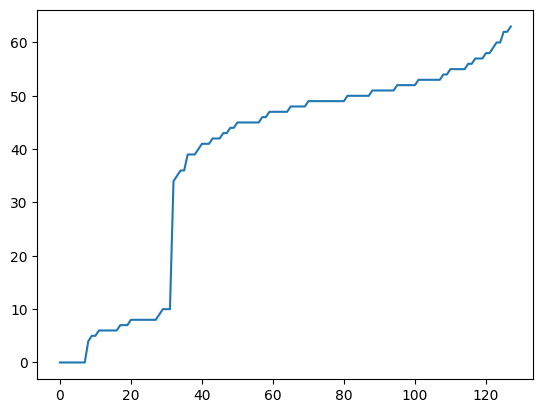

In [8]:
plt.plot(range(128), torch.sort(orthant_counts).values)

In [9]:
ZERO_ORTHANT_INDICES, LOW_ORTHANT_INDICES, HIGH_ORTHANT_INDICES = [], [], []
for i in range(128):
    if orthant_counts[i] == 0:
        ZERO_ORTHANT_INDICES.append(i)
    elif orthant_counts[i] <= 2*(LOW_COUNT+LOW_SPREAD): 
        LOW_ORTHANT_INDICES.append(i)
    else:
        HIGH_ORTHANT_INDICES.append(i)
len(ZERO_ORTHANT_INDICES), len(LOW_ORTHANT_INDICES), len(HIGH_ORTHANT_INDICES)

(8, 24, 96)

In [10]:
ZERO_ORTHANT_INDICES_FLIP, LOW_ORTHANT_INDICES_FLIP, HIGH_ORTHANT_INDICES_FLIP = [], [], []
for i in range(128):
    if orthant_counts[i] == 0:
        ZERO_ORTHANT_INDICES_FLIP.append(i)
    elif orthant_counts[i] <= 2*(LOW_COUNT+LOW_SPREAD):
        LOW_ORTHANT_INDICES_FLIP.append(i)
    else:
        HIGH_ORTHANT_INDICES_FLIP.append(i)
len(ZERO_ORTHANT_INDICES_FLIP), len(LOW_ORTHANT_INDICES_FLIP), len(HIGH_ORTHANT_INDICES_FLIP)

(8, 24, 96)

In [11]:
X_training_flip, Y_training_flip, orthant_counts_flip = generate_train_data(flips=flips)
X_training_flip.shape, Y_training_flip.shape, flips.sum()

(torch.Size([4937, 7]),
 torch.Size([4937, 1]),
 tensor(29., dtype=torch.float64))

#### Train-Validation split

In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(X_training, Y_training, test_size=0.2)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

(torch.Size([3920, 7]),
 torch.Size([981, 7]),
 torch.Size([3920, 1]),
 torch.Size([981, 1]))

In [13]:
X_train_flip, X_val_flip, Y_train_flip, Y_val_flip = train_test_split(X_training_flip, Y_training_flip, test_size=0.2)
X_train_flip.shape, X_val_flip.shape, Y_train_flip.shape, Y_val_flip.shape

(torch.Size([3949, 7]),
 torch.Size([988, 7]),
 torch.Size([3949, 1]),
 torch.Size([988, 1]))

#### Test data

In [14]:
X_test, Y_test = generate_test_data()
X_test.shape, Y_test.shape

(torch.Size([128, 128, 7]), torch.Size([128, 128, 1]))

In [15]:
X_test_flip, Y_test_flip = generate_test_data(flips=flips)
X_test_flip.shape, Y_test_flip.shape, flips.sum()

(torch.Size([128, 128, 7]),
 torch.Size([128, 128, 1]),
 tensor(29., dtype=torch.float64))

#### Data for hyperparameter tuning

In [16]:
from sklearn.utils import resample

X_train_cv, Y_train_cv = resample(X_train, Y_train, replace=False, n_samples=len(X_train)//5)
X_val_cv, Y_val_cv = resample(X_val, Y_val, replace=False, n_samples=len(X_val)//5)
X_train_cv.shape, X_val_cv.shape, Y_train_cv.shape, Y_val_cv.shape

(torch.Size([784, 7]),
 torch.Size([196, 7]),
 torch.Size([784, 1]),
 torch.Size([196, 1]))

In [17]:
X_train_flip_cv, Y_train_flip_cv = resample(X_train_flip, Y_train_flip, replace=False, n_samples=len(X_train_flip)//5)
X_val_flip_cv, Y_val_flip_cv = resample(X_val_flip, Y_val_flip, replace=False, n_samples=len(X_val_flip)//5)
X_train_flip_cv.shape, X_val_flip_cv.shape, Y_train_flip_cv.shape, Y_val_flip_cv.shape

(torch.Size([789, 7]),
 torch.Size([197, 7]),
 torch.Size([789, 1]),
 torch.Size([197, 1]))

## Neural network

In [18]:
device = 'cpu'

In [19]:
from torch import nn

class SimpleNN(nn.Module):
    def __init__(
        self,
        hidden_layers: int = 2,
        hidden_units: int = 32
    ) -> None:
        super().__init__()
        self.hidden_layers = hidden_layers
        self.hidden_units = hidden_units
        self.input = nn.Sequential(
            nn.Linear(in_features=7, out_features=hidden_units),
            nn.ReLU()
        )
        self.hidden = nn.Sequential()
        for i in range(hidden_layers):
            self.hidden.append(nn.Linear(in_features=hidden_units, out_features=hidden_units))
            self.hidden.append(nn.ReLU())
        self.output = nn.Sequential(
            nn.Linear(in_features=hidden_units, out_features=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.output(self.hidden(self.input(x)))


In [20]:
from scripts.utils import make_dataloader

train_dataloader, val_dataloader = make_dataloader(X_train, Y_train, batch_size=32, shuffle=True), make_dataloader(X_val, Y_val, batch_size=32, shuffle=True)
train_cv_dataloader, val_cv_dataloader = make_dataloader(X_train_cv, Y_train_cv, batch_size=32, shuffle=True), make_dataloader(X_val_cv, Y_val_cv, batch_size=32, shuffle=True)
train_flip_dataloader, val_flip_dataloader = make_dataloader(X_train_flip, Y_train_flip, batch_size=32, shuffle=True), make_dataloader(X_val_flip, Y_val_flip, batch_size=32, shuffle=True)
train_flip_cv_dataloader, val_flip_cv_dataloader = make_dataloader(X_train_flip_cv, Y_train_flip_cv, batch_size=32, shuffle=True), make_dataloader(X_val_flip_cv, Y_val_flip_cv, batch_size=32, shuffle=True)

In [21]:
depths = [1, 2, 3, 4, 5]
widths = [16, 32, 64]
lambdas = [0, 1e-7, 1e-6, 1e-5]
etas = [1e-2, 1e-3, 1e-4]
betass = [(0.9, 0.999), (0.9, 0.99), (0.8, 0.9)]

### Without class flipping

In [22]:
best_depth = None
best_width = None
best_lambda = None
best_eta = None
best_betas = None
best_score = -1

In [23]:
from scripts.metrics import BinaryAccuracy
from scripts.train import train_model
from scripts.test import predict

count = 0
total = len(depths) * len(widths) * len(lambdas) * len(etas) * len(betass)
EPOCHS = 50
for depth in depths:
    for width in widths:
        for lambda_i in lambdas:
            for eta in etas:
                for betas in betass:
                    model = SimpleNN(hidden_layers=depth, hidden_units=width).to(device)
                    loss_fn = torch.nn.BCELoss()
                    optimizer = torch.optim.Adam(params=model.parameters(), lr=eta, betas=betas, weight_decay=lambda_i)
                    metric = BinaryAccuracy()
                    history = train_model(
                        model=model,
                        train_dataloader=train_cv_dataloader,
                        val_dataloader=val_cv_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        metric=metric,
                        epochs=EPOCHS,
                        verbose=0,
                        device=device
                    )
                    count += 1
                    score = history['val_score'][-1]
                    print(f'Model {count} of {total} trained. Validation accuracy: {score}')
                    if score > best_score:
                        best_score = score
                        best_depth = depth
                        best_width = width
                        best_lambda = lambda_i
                        best_eta = eta
                        best_betas = betas

print(f'Results:\nDepth: {best_depth}\nWidth: {best_width}\nLambda: {best_lambda}\nEta: {best_eta}\nBetas: {best_betas}\nAccuracy after {EPOCHS} epochs: {best_score}')

Model 1 of 540 trained. Validation accuracy: 0.5669642686843872
Model 2 of 540 trained. Validation accuracy: 0.5223214030265808
Model 3 of 540 trained. Validation accuracy: 0.5357142686843872
Model 4 of 540 trained. Validation accuracy: 0.5267857313156128
Model 5 of 540 trained. Validation accuracy: 0.4910714328289032
Model 6 of 540 trained. Validation accuracy: 0.53125
Model 7 of 540 trained. Validation accuracy: 0.4464285671710968
Model 8 of 540 trained. Validation accuracy: 0.5357142686843872
Model 9 of 540 trained. Validation accuracy: 0.5267857313156128
Model 10 of 540 trained. Validation accuracy: 0.6517857313156128
Model 11 of 540 trained. Validation accuracy: 0.53125
Model 12 of 540 trained. Validation accuracy: 0.5446428656578064
Model 13 of 540 trained. Validation accuracy: 0.5
Model 14 of 540 trained. Validation accuracy: 0.5
Model 15 of 540 trained. Validation accuracy: 0.5491071343421936
Model 16 of 540 trained. Validation accuracy: 0.6071428656578064
Model 17 of 540 train

In [24]:
best_model_nn = SimpleNN(hidden_layers=best_depth, hidden_units=best_width).to(device)

In [25]:
from scripts.metrics import BinaryAccuracy

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=best_model_nn.parameters(), lr=best_eta, betas=best_betas, weight_decay=best_lambda)
metric = BinaryAccuracy()

In [26]:
from scripts.utils import EarlyStopping

early_stop = EarlyStopping(patience=20, min_delta=1e-4)

In [27]:
from scripts.train import train_model

history = train_model(
    model=best_model_nn,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=500,
    early_stopping=early_stop,
    device=device,
    return_models=True
)

Training model for 500 epochs. Early stopping enabled.
Epoch: 1 => Train loss: 0.693945, Train score: 0.500000, Val loss: 0.693445, Val score: 0.501776
Epoch: 2 => Train loss: 0.692934, Train score: 0.513465, Val loss: 0.693491, Val score: 0.490687
Epoch: 3 => Train loss: 0.692342, Train score: 0.528963, Val loss: 0.694260, Val score: 0.504272
Epoch: 4 => Train loss: 0.691656, Train score: 0.523628, Val loss: 0.697271, Val score: 0.499760
Epoch: 5 => Train loss: 0.690779, Train score: 0.535061, Val loss: 0.697634, Val score: 0.495248
Epoch: 6 => Train loss: 0.689123, Train score: 0.546748, Val loss: 0.698558, Val score: 0.511377
Epoch: 7 => Train loss: 0.687979, Train score: 0.548018, Val loss: 0.700108, Val score: 0.497264
Epoch: 8 => Train loss: 0.686655, Train score: 0.553354, Val loss: 0.697418, Val score: 0.530962
Epoch: 9 => Train loss: 0.685315, Train score: 0.553608, Val loss: 0.693457, Val score: 0.537058
Epoch: 10 => Train loss: 0.681112, Train score: 0.569614, Val loss: 0.69

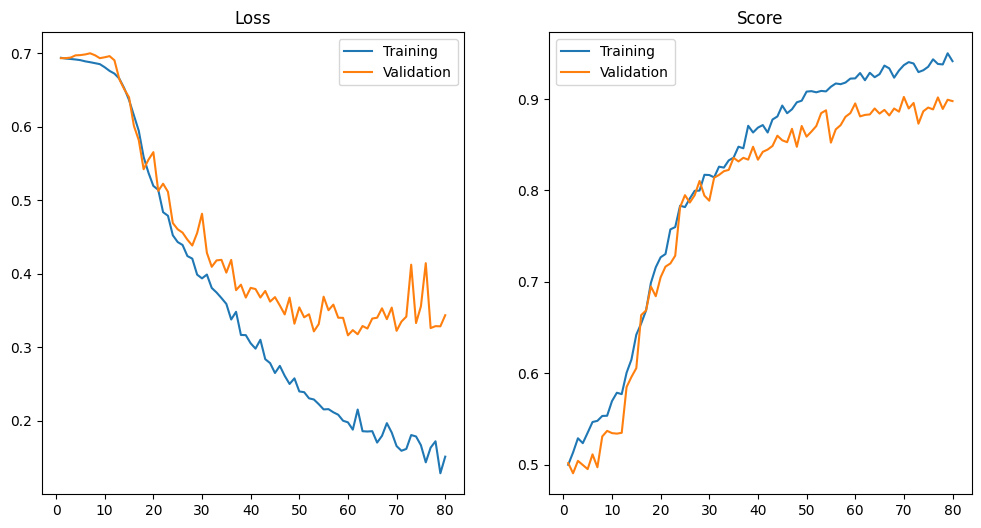

In [28]:
from scripts.utils import plot_train_history

plot_train_history(history)

In [29]:
from scripts.test import predict

scores_nn = torch.tensor([
    metric(
        predict(best_model_nn, X_test[i], device),
        Y_test[i]
    ) for i in range(128)
])

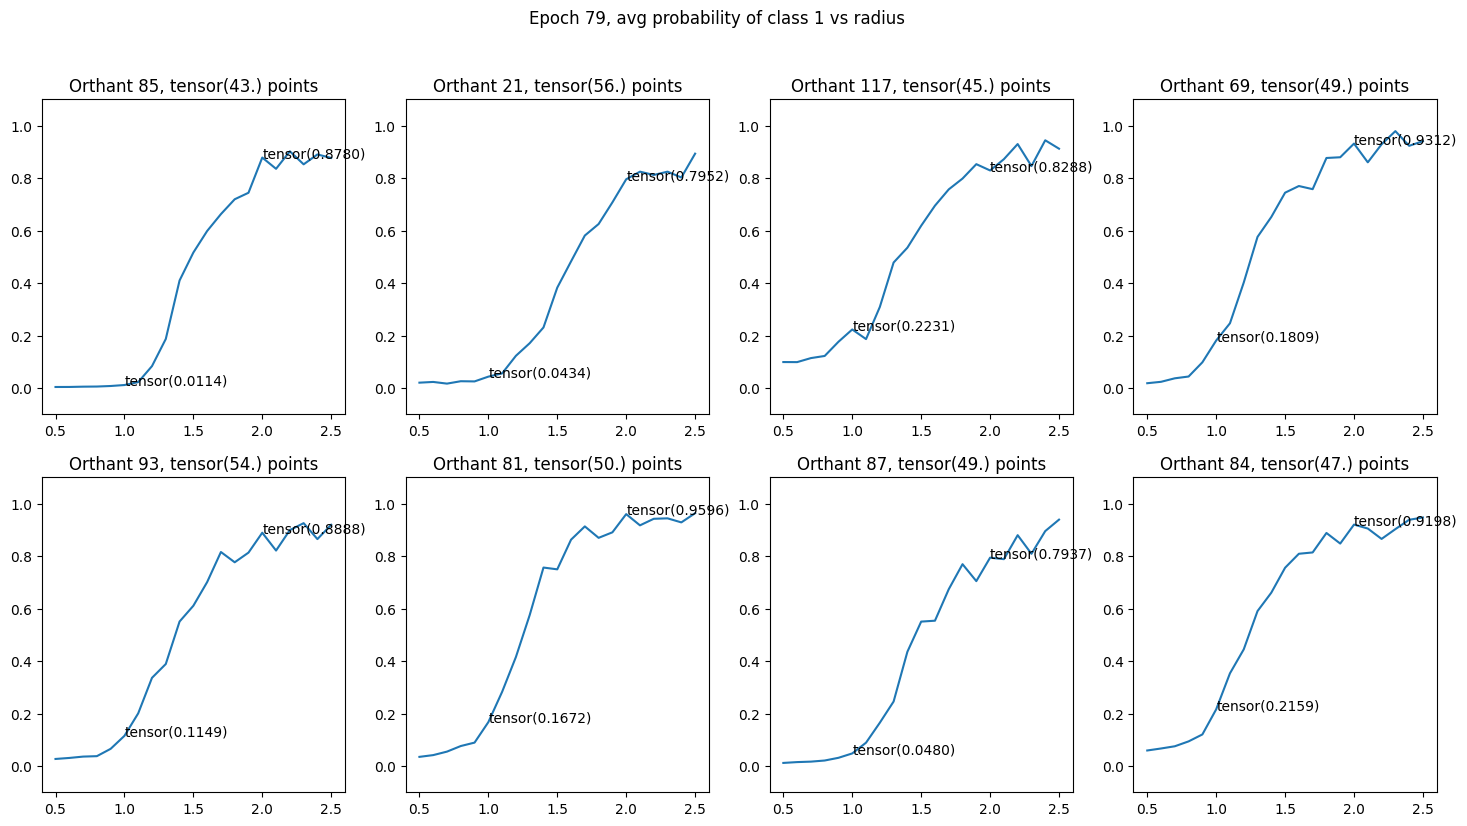

In [30]:
from scripts.utils import plot_radial_visualization

plot_radial_visualization(
    models=history['models'],
    mp4_save_file_name='radial',
    orthant_counts=orthant_counts,
    fps=4,
    device=device
) # track progress if possible, add a verbose parameter

In [31]:
# from scripts.utils import plot_2d_visualization

# plot_2d_visualization(
#     X_train=X_train,
#     Y_train=Y_train,
#     models=history['models'],
#     gif_save_file_name='2DProjection_1'
# )

### With class flipping in random orthants

In [32]:
best_depth_flip = None
best_width_flip = None
best_lambda_flip = None
best_eta_flip = None
best_betas_flip = None
best_score_flip = -1

In [33]:
count = 0
total = len(depths) * len(widths) * len(lambdas) * len(etas) * len(betass)
EPOCHS = 50
for depth in depths:
    for width in widths:
        for lambda_i in lambdas:
            for eta in etas:
                for betas in betass:
                    model = SimpleNN(hidden_layers=depth, hidden_units=width).to(device)
                    loss_fn = torch.nn.BCELoss()
                    optimizer = torch.optim.Adam(params=model.parameters(), lr=eta, betas=betas, weight_decay=lambda_i)
                    metric = BinaryAccuracy()
                    history = train_model(
                        model=model,
                        train_dataloader=train_flip_cv_dataloader,
                        val_dataloader=val_flip_cv_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        metric=metric,
                        epochs=EPOCHS,
                        verbose=0,
                        device=device
                    )
                    count += 1
                    score = history['val_score'][-1]
                    print(f'Model {count} of {total} trained. Validation accuracy: {score}')
                    if score > best_score_flip:
                        best_score_flip = score
                        best_depth_flip = depth
                        best_width_flip = width
                        best_lambda_flip = lambda_i
                        best_eta_flip = eta
                        best_betas_flip = betas

print(f'Results:\nDepth: {best_depth_flip}\nWidth: {best_width_flip}\nLambda: {best_lambda_flip}\nEta: {best_eta_flip}\nBetas: {best_betas_flip}\nAccuracy after {EPOCHS} epochs: {best_score_flip}')

Model 1 of 540 trained. Validation accuracy: 0.5249999761581421
Model 2 of 540 trained. Validation accuracy: 0.5875000357627869
Model 3 of 540 trained. Validation accuracy: 0.5544642806053162
Model 4 of 540 trained. Validation accuracy: 0.5321428179740906
Model 5 of 540 trained. Validation accuracy: 0.5607143044471741
Model 6 of 540 trained. Validation accuracy: 0.49196428060531616
Model 7 of 540 trained. Validation accuracy: 0.5098214149475098
Model 8 of 540 trained. Validation accuracy: 0.6098214387893677
Model 9 of 540 trained. Validation accuracy: 0.5321428179740906
Model 10 of 540 trained. Validation accuracy: 0.543749988079071
Model 11 of 540 trained. Validation accuracy: 0.4598214328289032
Model 12 of 540 trained. Validation accuracy: 0.4348214268684387
Model 13 of 540 trained. Validation accuracy: 0.49017858505249023
Model 14 of 540 trained. Validation accuracy: 0.49464288353919983
Model 15 of 540 trained. Validation accuracy: 0.5803571343421936
Model 16 of 540 trained. Validat

In [34]:
best_model_flip_nn = SimpleNN(hidden_layers=best_depth_flip, hidden_units=best_width_flip).to(device)

In [35]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=best_model_flip_nn.parameters(), lr=best_eta_flip, betas=best_betas_flip, weight_decay=best_lambda_flip)
metric = BinaryAccuracy()

In [36]:
early_stop = EarlyStopping(patience=20, min_delta=1e-4)

In [37]:
history = train_model(
    model=best_model_flip_nn,
    train_dataloader=train_flip_dataloader,
    val_dataloader=val_flip_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=500,
    early_stopping=early_stop,
    device=device
)

Training model for 500 epochs. Early stopping enabled.
Epoch: 1 => Train loss: 0.694138, Train score: 0.481157, Val loss: 0.692945, Val score: 0.521745
Epoch: 2 => Train loss: 0.692990, Train score: 0.511011, Val loss: 0.692521, Val score: 0.514401
Epoch: 3 => Train loss: 0.692493, Train score: 0.521867, Val loss: 0.691731, Val score: 0.537442
Epoch: 4 => Train loss: 0.690389, Train score: 0.537085, Val loss: 0.693651, Val score: 0.511953
Epoch: 5 => Train loss: 0.688551, Train score: 0.543269, Val loss: 0.694082, Val score: 0.503600
Epoch: 6 => Train loss: 0.689345, Train score: 0.541486, Val loss: 0.691588, Val score: 0.530674
Epoch: 7 => Train loss: 0.687132, Train score: 0.550578, Val loss: 0.695182, Val score: 0.525778
Epoch: 8 => Train loss: 0.684965, Train score: 0.562015, Val loss: 0.694253, Val score: 0.522465
Epoch: 9 => Train loss: 0.683294, Train score: 0.568199, Val loss: 0.702924, Val score: 0.517857
Epoch: 10 => Train loss: 0.683140, Train score: 0.568354, Val loss: 0.69

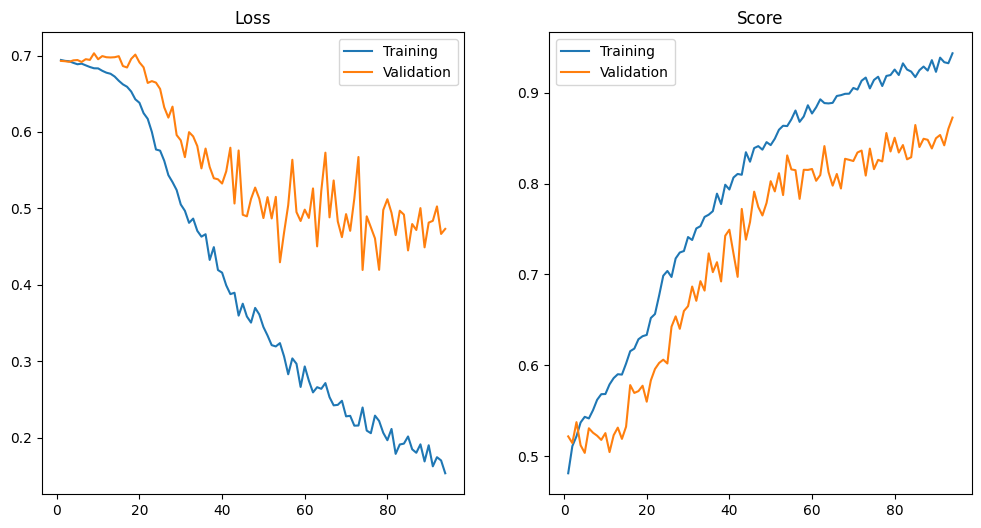

In [38]:
plot_train_history(history)

In [39]:
scores_flip_nn = torch.tensor([
    metric(
        predict(best_model_flip_nn, X_test_flip[i], device),
        Y_test_flip[i]
    ) for i in range(128)
])

### Orthant performance plot

Text(0.5, 0.98, 'Score vs no. of points for each orthant, NN')

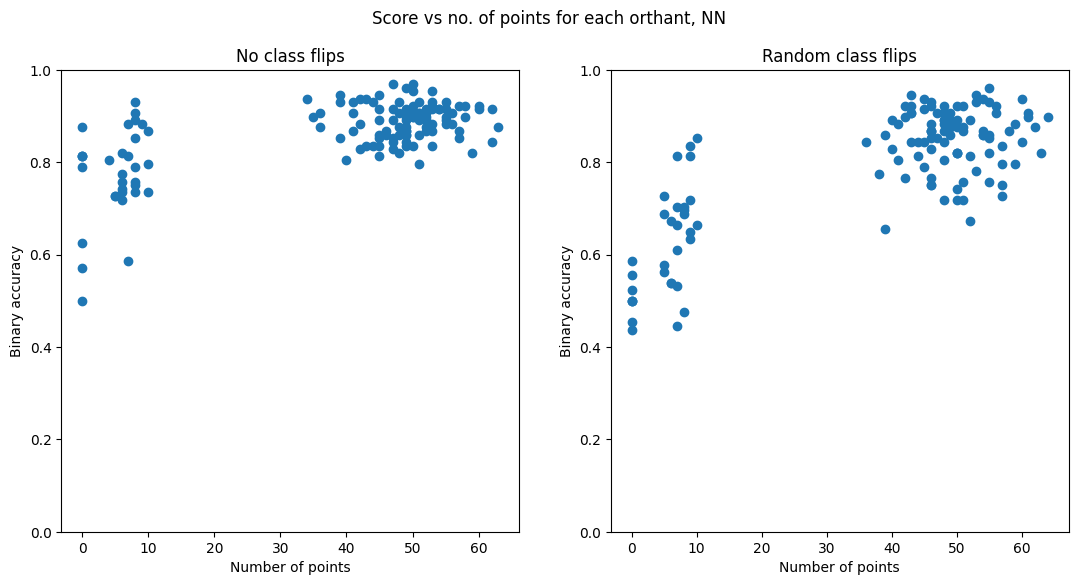

In [40]:
plt.figure(figsize=(13, 6))

plt.subplot(121)
plt.scatter(orthant_counts, scores_nn)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.ylim((0., 1.))
plt.title('No class flips')

plt.subplot(122)
plt.scatter(orthant_counts_flip, scores_flip_nn)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.ylim((0., 1.))
plt.title('Random class flips')

plt.suptitle('Score vs no. of points for each orthant, NN')

In [41]:
from scipy.stats import pearsonr

pearsonr(orthant_counts, scores_nn).statistic, pearsonr(orthant_counts_flip, scores_flip_nn).statistic

(0.6428727273914125, 0.7824542778685071)

In [42]:
scores_nn.mean(), scores_flip_nn.mean()

(tensor(0.8603), tensor(0.7949))

In [43]:
print('Performance in empty orthants: ', scores_nn[ZERO_ORTHANT_INDICES].mean(), scores_flip_nn[ZERO_ORTHANT_INDICES_FLIP].mean())
print('Performance in rare orthants: ', scores_nn[LOW_ORTHANT_INDICES].mean(), scores_flip_nn[LOW_ORTHANT_INDICES_FLIP].mean())
print('Performance in typical orthants: ', scores_nn[HIGH_ORTHANT_INDICES].mean(), scores_flip_nn[HIGH_ORTHANT_INDICES_FLIP].mean())

Performance in empty orthants:  tensor(0.7246) tensor(0.7559)
Performance in rare orthants:  tensor(0.7907) tensor(0.8200)
Performance in typical orthants:  tensor(0.8890) tensor(0.7918)


Okay, maybe a neural network can find symmetry? Can an SVM do this too? Is the test data too similar to training?

## SVM

In [44]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer
from scripts.ntk import NTK
from sklearn.model_selection import GridSearchCV

In [45]:
ntk = NTK(best_model_nn).get_ntk

In [46]:
model_base_ntk = SVC(kernel=ntk)
params_ntk = {
    'C': np.logspace(-5, 5, 11)
}

gammas = np.logspace(-5, 5, 11).tolist()
gammas.append('scale')
gammas.append('auto')
model_base_rbf = SVC(kernel='rbf')
params_rbf = {
    'C': np.logspace(-5, 5, 11),
    'gamma': gammas
}

scorer = make_scorer(accuracy_score)

### Without class flipping

In [47]:
model_cv_ntk = GridSearchCV(
    estimator=model_base_ntk,
    param_grid=params_ntk,
    scoring=scorer,
    n_jobs=5,
    refit=False,
    verbose=3
)
model_cv_ntk.fit(X_train_cv, Y_train_cv.squeeze())
best_params_ntk = model_cv_ntk.best_params_
best_params_ntk

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5] END ...........................C=1e-05;, score=0.510 total time=   1.2s
[CV 5/5] END ...........................C=1e-05;, score=0.506 total time=   1.2s
[CV 2/5] END ...........................C=1e-05;, score=0.503 total time=   1.2s
[CV 3/5] END ...........................C=1e-05;, score=0.503 total time=   1.2s
[CV 4/5] END ...........................C=1e-05;, score=0.503 total time=   1.2s
[CV 1/5] END ..........................C=0.0001;, score=0.510 total time=   1.1s
[CV 2/5] END ..........................C=0.0001;, score=0.503 total time=   1.2s
[CV 3/5] END ..........................C=0.0001;, score=0.503 total time=   1.2s
[CV 4/5] END ..........................C=0.0001;, score=0.503 total time=   1.2s
[CV 5/5] END ..........................C=0.0001;, score=0.506 total time=   1.2s
[CV 1/5] END ...........................C=0.001;, score=0.541 total time=   1.2s
[CV 3/5] END ...........................C=0.001;

{'C': 1000.0}

In [48]:
model_cv_rbf = GridSearchCV(
    estimator=model_base_rbf,
    param_grid=params_rbf,
    scoring=scorer,
    n_jobs=5,
    refit=False,
    verbose=3
)
model_cv_rbf.fit(X_train_cv, Y_train_cv.squeeze())
best_params_rbf = model_cv_rbf.best_params_
best_params_rbf

Fitting 5 folds for each of 143 candidates, totalling 715 fits
[CV 1/5] END ..............C=1e-05, gamma=1e-05;, score=0.510 total time=   0.0s
[CV 4/5] END ..............C=1e-05, gamma=1e-05;, score=0.503 total time=   0.0s
[CV 5/5] END ..............C=1e-05, gamma=1e-05;, score=0.506 total time=   0.0s
[CV 3/5] END ..............C=1e-05, gamma=1e-05;, score=0.503 total time=   0.0s
[CV 2/5] END ..............C=1e-05, gamma=1e-05;, score=0.503 total time=   0.0s
[CV 2/5] END .............C=1e-05, gamma=0.0001;, score=0.503 total time=   0.0s
[CV 1/5] END .............C=1e-05, gamma=0.0001;, score=0.510 total time=   0.0s
[CV 3/5] END .............C=1e-05, gamma=0.0001;, score=0.503 total time=   0.0s
[CV 4/5] END .............C=1e-05, gamma=0.0001;, score=0.503 total time=   0.0s
[CV 5/5] END .............C=1e-05, gamma=0.0001;, score=0.506 total time=   0.0s
[CV 1/5] END ..............C=1e-05, gamma=0.001;, score=0.510 total time=   0.0s
[CV 3/5] END ..............C=1e-05, gamma=0.00

{'C': 10.0, 'gamma': 1.0}

In [49]:
best_score_ntk = max(model_cv_ntk.cv_results_['mean_test_score'])
best_score_rbf = max(model_cv_rbf.cv_results_['mean_test_score'])

if best_score_rbf >= best_score_ntk:
    best_model_km = SVC(C=best_params_rbf['C'], kernel='rbf', gamma=best_params_rbf['gamma'])
else:
    best_model_km = SVC(C=best_params_ntk['C'], kernel=ntk)

In [50]:
best_model_km.fit(X_train, Y_train.squeeze())

SVC(C=1000.0,
    kernel=<bound method NTK.get_ntk of <scripts.ntk.NTK object at 0x7f27848fad70>>)

In [51]:
preds_train, preds_val = best_model_km.predict(X_train), best_model_km.predict(X_val)
score_train, score_val = accuracy_score(Y_train.squeeze(), preds_train), accuracy_score(Y_val.squeeze(), preds_val)
score_train, score_val

(0.9938775510204082, 0.8572884811416922)

In [52]:
scores_km = np.array([
    accuracy_score(
        best_model_km.predict(X_test[i]),
        Y_test[i].squeeze()
    ) for i in range(128)
])

### With class flipping in random orthants

In [53]:
model_cv_ntk = GridSearchCV(
    estimator=model_base_ntk,
    param_grid=params_ntk,
    scoring=scorer,
    n_jobs=5,
    refit=False,
    verbose=3
)
model_cv_ntk.fit(X_train_flip_cv, Y_train_flip_cv.squeeze())
best_params_flip_ntk = model_cv_ntk.best_params_
best_params_flip_ntk

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 3/5] END ...........................C=1e-05;, score=0.519 total time=   1.1s
[CV 1/5] END ...........................C=1e-05;, score=0.513 total time=   1.2s
[CV 4/5] END ...........................C=1e-05;, score=0.519 total time=   1.2s
[CV 5/5] END ...........................C=1e-05;, score=0.516 total time=   1.2s
[CV 2/5] END ...........................C=1e-05;, score=0.519 total time=   1.2s
[CV 1/5] END ..........................C=0.0001;, score=0.513 total time=   1.1s
[CV 2/5] END ..........................C=0.0001;, score=0.519 total time=   1.1s
[CV 4/5] END ..........................C=0.0001;, score=0.519 total time=   1.2s
[CV 3/5] END ..........................C=0.0001;, score=0.519 total time=   1.2s
[CV 5/5] END ..........................C=0.0001;, score=0.516 total time=   1.2s
[CV 1/5] END ...........................C=0.001;, score=0.506 total time=   1.1s
[CV 3/5] END ...........................C=0.001;

{'C': 100.0}

In [54]:
model_cv_rbf = GridSearchCV(
    estimator=model_base_rbf,
    param_grid=params_rbf,
    scoring=scorer,
    n_jobs=5,
    refit=False,
    verbose=3
)
model_cv_rbf.fit(X_train_flip_cv, Y_train_flip_cv.squeeze())
best_params_flip_rbf = model_cv_rbf.best_params_
best_params_flip_rbf

Fitting 5 folds for each of 143 candidates, totalling 715 fits
[CV 2/5] END ..............C=1e-05, gamma=1e-05;, score=0.519 total time=   0.0s
[CV 1/5] END ..............C=1e-05, gamma=1e-05;, score=0.513 total time=   0.0s
[CV 3/5] END ..............C=1e-05, gamma=1e-05;, score=0.519 total time=   0.0s
[CV 5/5] END ..............C=1e-05, gamma=1e-05;, score=0.516 total time=   0.0s
[CV 4/5] END ..............C=1e-05, gamma=1e-05;, score=0.519 total time=   0.0s
[CV 1/5] END .............C=1e-05, gamma=0.0001;, score=0.513 total time=   0.0s
[CV 2/5] END .............C=1e-05, gamma=0.0001;, score=0.519 total time=   0.0s
[CV 3/5] END .............C=1e-05, gamma=0.0001;, score=0.519 total time=   0.0s
[CV 4/5] END .............C=1e-05, gamma=0.0001;, score=0.519 total time=   0.0s
[CV 5/5] END .............C=1e-05, gamma=0.0001;, score=0.516 total time=   0.0s
[CV 3/5] END ..............C=1e-05, gamma=0.001;, score=0.519 total time=   0.0s
[CV 5/5] END ..............C=1e-05, gamma=0.00

{'C': 1.0, 'gamma': 1.0}

In [55]:
best_score_flip_ntk = max(model_cv_ntk.cv_results_['mean_test_score'])
best_score_flip_rbf = max(model_cv_rbf.cv_results_['mean_test_score'])

if best_score_flip_rbf >= best_score_flip_ntk:
    best_model_flip_km = SVC(C=best_params_flip_rbf['C'], kernel='rbf', gamma=best_params_flip_rbf['gamma'])
else:
    best_model_flip_km = SVC(C=best_params_flip_ntk['C'], kernel=ntk)

In [56]:
best_model_flip_km.fit(X_train_flip, Y_train_flip.squeeze())

SVC(gamma=1.0)

In [57]:
preds_train, preds_val = best_model_flip_km.predict(X_train_flip), best_model_flip_km.predict(X_val_flip)
score_train, score_val = accuracy_score(Y_train_flip.squeeze(), preds_train), accuracy_score(Y_val_flip.squeeze(), preds_val)
score_train, score_val

(1.0, 0.9362348178137652)

In [58]:
scores_flip_km = np.array([
    accuracy_score(
        best_model_flip_km.predict(X_test_flip[i]),
        Y_test_flip[i].squeeze()
    ) for i in range(128)
])

### Orthant performance plot

Text(0.5, 0.98, 'Score vs no. of points for each orthant, SVM')

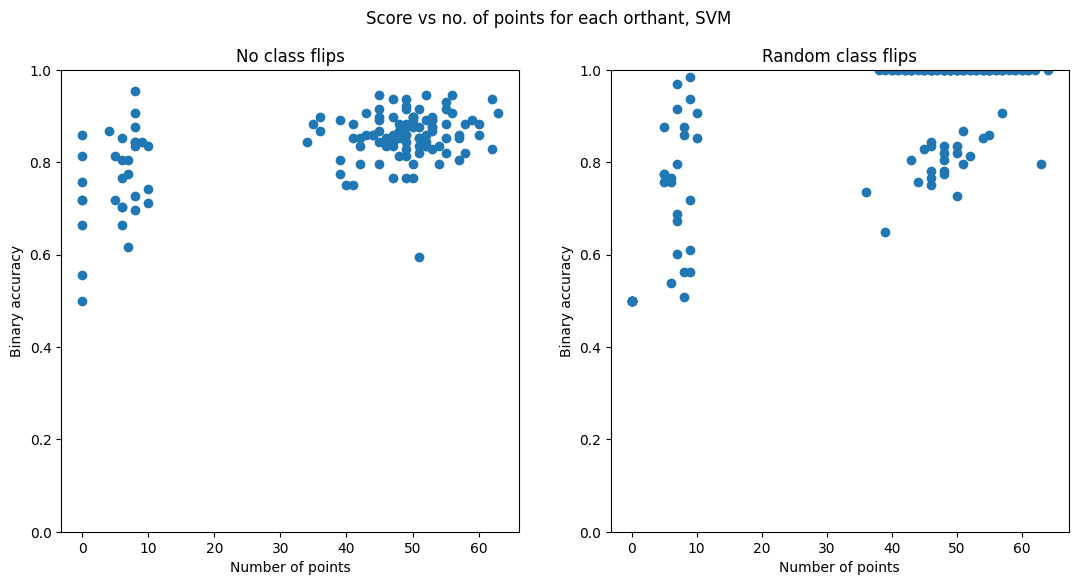

In [59]:
plt.figure(figsize=(13, 6))

plt.subplot(121)
plt.scatter(orthant_counts, scores_km)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.ylim((0., 1.))
plt.title('No class flips')

plt.subplot(122)
plt.scatter(orthant_counts_flip, scores_flip_km)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.ylim((0., 1.))
plt.title('Random class flips')

plt.suptitle('Score vs no. of points for each orthant, SVM')

In [60]:
from scipy.stats import pearsonr

pearsonr(orthant_counts, scores_km).statistic, pearsonr(orthant_counts_flip, scores_flip_km).statistic

(0.5424964697434358, 0.7188305043531835)

In [61]:
scores_km.mean(), scores_flip_km.mean()

(0.83526611328125, 0.8851318359375)

In [62]:
print('Performance in empty orthants: ', scores_km[ZERO_ORTHANT_INDICES].mean(), scores_flip_km[ZERO_ORTHANT_INDICES_FLIP].mean())
print('Performance in rare orthants: ', scores_km[LOW_ORTHANT_INDICES].mean(), scores_flip_km[LOW_ORTHANT_INDICES_FLIP].mean())
print('Performance in typical orthants: ', scores_km[HIGH_ORTHANT_INDICES].mean(), scores_flip_km[HIGH_ORTHANT_INDICES_FLIP].mean())

Performance in empty orthants:  0.6982421875 0.85546875
Performance in rare orthants:  0.7874348958333334 0.9069010416666666
Performance in typical orthants:  0.858642578125 0.8821614583333334
